In [1]:
#https://www.kaggle.com/datasets/subirmaity/mosfet-characteristics?resource=download

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#read the file of first measurement (performed at 2016-09-30) as a data frame:
df = pd.read_csv('training_data.csv')

In [4]:
#show the head of the data frame:
df.head(20)

,Vds,Vgs,Id
0,0.00,0.0,0.000000e+00
1,0.02,0.0,2.770000e-14
2,0.04,0.0,4.790000e-14
3,0.06,0.0,6.900000e-14
4,0.08,0.0,8.950000e-14
5,0.10,0.0,1.100000e-13
6,0.12,0.0,1.300000e-13
7,0.14,0.0,1.500000e-13
8,0.16,0.0,1.700000e-13
9,0.18,0.0,1.900000e-13


In [5]:
#show the details of the data frame 
#(number and list of the columns names,data type of each column,...)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25351 entries, 0 to 25350
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vds     25351 non-null  float64
 1   Vgs     25351 non-null  float64
 2   Id      25351 non-null  float64
dtypes: float64(3)
memory usage: 594.3 KB


In [6]:
#show the shortened form of the full data frame (the first and last few rows are displayed)
df

,Vds,Vgs,Id
0,0.00,0.0,0.000000e+00
1,0.02,0.0,2.770000e-14
2,0.04,0.0,4.790000e-14
3,0.06,0.0,6.900000e-14
4,0.08,0.0,8.950000e-14
...,...,...,...
25346,4.92,5.0,1.430000e-04
25347,4.94,5.0,1.430000e-04
25348,4.96,5.0,1.430000e-04
25349,4.98,5.0,1.430000e-04


In [7]:
#show the list of total null values in each column:
df.isnull().sum()

Vds    0
Vgs    0
Id     0
dtype: int64

In [80]:
#the main goal of the project is to predict the ? of a given MOSFET
#based on two meseaured features (vds (drain-source voltage, and vgs (gate-source voltage))
#The Id (current) column is the prediction object which will be used for regression

In [8]:
#get the list of the values of s specific column of the data frame:
df['Id']

0        0.000000e+00
1        2.770000e-14
2        4.790000e-14
3        6.900000e-14
4        8.950000e-14
             ...     
25346    1.430000e-04
25347    1.430000e-04
25348    1.430000e-04
25349    1.430000e-04
25350    1.440000e-04
Name: Id, Length: 25351, dtype: float64

In [9]:
#get the list of unique values of specific column of the data frame:
df["Id"].unique()

array([0.00e+00, 2.77e-14, 4.79e-14, ..., 1.42e-04, 1.43e-04, 1.44e-04])

In [10]:
#get number of unique values of specific column of the data frame:
df["Id"].nunique()

5038

In [11]:
df_corr = df.corr()

In [12]:
df_corr.head()

,Vds,Vgs,Id
Vds,1.000000e+00,2.205808e-18,0.109298
Vgs,2.205808e-18,1.000000e+00,0.855220
Id,1.092977e-01,8.552196e-01,1.000000


In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
X_train = df.drop('Id',axis=1).values
y_train = df['Id'].values

In [22]:
X_train = scaler.fit_transform(X_train)

In [23]:
from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score

import tensorflow as tf
import keras
import tensorflow.keras.models as Sequential
import tensorflow.keras.layers as Dense

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV

import os

In [24]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cvscores = []
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    X_train[train] = scaler.fit_transform(X_train[train])
    X_train[test] = scaler.transform(X_train[test])

    # define the function to be used as build function in KerasRegressor which itself is meta 
    #estimator to define the model
    #In the definition of the function, all parameters those will be changed 
    #(as variables in gridsearchCV) should be passed into the function

    def create_model(optimizer,learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(neuron1,input_dim=2,kernel_initializer=init,activation=activation_function))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Dense(neuron2,input_dim=neuron1,kernel_initializer=init,activation=activation_function))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        #model.add(tf.keras.layers.Dense(neuron3,input_dim=neuron2,kernel_initializer=init,activation=activation_function))
        #model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
  
    #Initializers define the way to set the initial random weights of Keras layers.
    
        model.compile(loss = 'mse',optimizer=optimizer,metrics=['accuracy'])
        return model

    # create model
    #model = KerasClassifier(build_fn=create_model, verbose=0)
    model = KerasRegressor(build_fn=create_model, verbose=1)

    # Define the grid search parameters
    #optimizers = ['rmsprop','adam']
    optimizers = ['adam']
    #init = ['glorot_uniform','normal','uniform']
    #init = ['glorot_uniform','normal']
    init = ['normal']
    epochs = [10,30]
    batch_size = [32,64]
    learning_rate = [0.001,0.1]
    dropout_rate = [0.0,0.2]
    #activation_function = ['softmax','relu','tanh','linear']
    #activation_function = ['relu','tanh']
    activation_function = ['relu']
    #init = ['uniform','normal','zero']
    #init = ['uniform','normal']
    init = ['normal']
    neuron1 = [2,4]
    neuron2 = [2,4]
#in order to see the effect of number of neurons on the model, neuron1 and neuron 2 as variable
#in grid search chosen. However to bring the computation cost low, two values just considered.
#81 is the lowest number of the neurons (number of features) and 91 (arbitrary value larger than 81)
#The similar procedure is considered for some other parameters.

    # Make a dictionary of the grid search parameters
    param_grids = dict(optimizer=optimizers, batch_size=batch_size, epochs=epochs,\
                   learning_rate=learning_rate, dropout_rate=dropout_rate, init=init,\
                   activation_function=activation_function, neuron1=neuron1,neuron2=neuron2)

    # Build and fit the GridSearchCV
    #grid = GridSearchCV(estimator=model,param_grid=param_grids,cv=KFold(),verbose=10,n_jobs=-1)
    grid = GridSearchCV(estimator=model,param_grid=param_grids,verbose=1,n_jobs=-1)
    #n_jobs: number of processes you wish to run in parallel for this task if it -1 it will use all available processors.

    #grid_result = grid.fit(X_standard)
    #grid_result = grid.fit(X,y)
    grid_result = grid.fit(X_train[train],y_train[train])

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param)) 
   
    
    # Generate a print for each k
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Define callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    #mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    checkpoint_path = f'./Jason-with-split/{fold_no}'
    os.mkdir(checkpoint_path)
    mc =ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
    
    # Fit the model
    model.fit(X_train[train], y_train[train], validation_data=(X_train[test],y_train[test]), epochs=300, batch_size=64, verbose=1, callbacks=[es, mc])
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'fold number: {fold_no}')   
    print("%s: %.2f%%" % (model.metrics_names[0], scores))   
    
    cvscores.append(scores)
    # Increase fold number
    fold_no = fold_no + 1
print("mean loss:%.2f%% -standard deviation:(+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 135.0min
C:\Users\NN\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 164.1min


KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

In [27]:
# load the saved model
saved_model_best = tf.keras.models.load_model('./Jason-with-split/2')

# evaluate the model
#_, train_acc = saved_model.evaluate(X_train[train], y_train[train], verbose=0)
#_, test_acc = saved_model.evaluate(X_train[test], y_train[test], verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

#train_loss = saved_model.evaluate(X_train[train], y_train[train], verbose=0)
#test_loss = saved_model.evaluate(X_train[test], y_train[test], verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

train_loss = saved_model_best.evaluate(X_train[train], y_train[train], verbose=0)
test_loss = saved_model_best.evaluate(X_train[test], y_train[test], verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

Train: 371.291, Test: 369.131


In [28]:
loss_df = pd.DataFrame(model.history.history)

<AxesSubplot:>

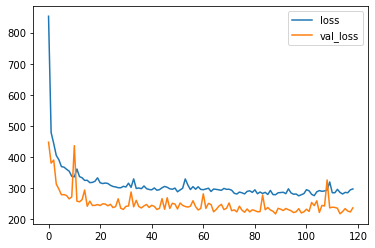

In [29]:
loss_df.plot()